# dPCA

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.cluster import KMeans
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from dPCA import dPCA

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0.0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequences per trial epoch

In [5]:
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'epoch_sequences_10_03-11-2025')
all_sequences = pickle.load(open(filename, 'rb'))

In [6]:
design_df = all_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = design_df.keys()[-4:]

In [7]:
df = design_df.copy()
df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
df['side'] = df['choice'].copy()
df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'

df['session'] = df['sample'].str.split().str[:1].str.join('')
df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')

In [8]:

df['contrast'] = df['contrast'].astype(float)
df['block'] = df['block'].astype(float)


df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
df.loc[df['choice']=='left', 'choice'] = 0
df.loc[df['choice']=='right', 'choice'] = 1

df.loc[df['feedback']=='correct', 'feedback'] = 1
df.loc[df['feedback']=='incorrect', 'feedback'] = 0

# Prepare for dPCA

## Multiple variables

In [245]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

vars = ['feedback', 'side']
var_letters = ['fm']

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]

# Stimulus 

stimulus_count = len(df[vars[0]].unique())
stimulus_values = df[vars[0]]
stimulus_types = df[vars[0]].unique()
stimulus_types.sort()
mouse_names = df[vars[1]]
mouse_unique_names = df[vars[1]].unique()

trials_per_condition = 1000

# Initialize matrices
X_frame = np.zeros((trials_per_condition, use_states, stimulus_count, 2, timesteps)) * np.nan
X_frame_mean = np.zeros((use_states, stimulus_count, 2, timesteps)) * np.nan


for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])
    
    for s, stimulus in enumerate(stimulus_types):
        for m, mouse in enumerate(mouse_unique_names):
            stimulus_indices = np.where(stimulus_values==stimulus)
            mouse_indices = np.where(mouse_names==mouse)
            intersect_index = np.intersect1d(stimulus_indices, mouse_indices)
            
            #if len(intersect_index) >= trials_per_condition:
            X_frame[:, :, s, m, t] = encoded_arr[intersect_index][:trials_per_condition]
            X_frame_mean[:, s, m, t] = np.mean(encoded_arr[intersect_index][:trials_per_condition], axis=0)
            #else:
            #    print(len(intersect_index))

In [246]:
np.shape(encoded_arr[intersect_index][:trials_per_condition])

(1000, 16)

In [247]:
np.shape(X_frame_mean)

(16, 2, 2, 40)

In [20]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

var = 'mouse_name'

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]

# Stimulus 
stimulus_count = len(df[var].unique())
stimulus_values = df[var]
stimulus_types = df[var].unique()
stimulus_types.sort()
trials_per_condition = np.min(df[var].value_counts())

# Initialize matrices
X_frame = np.zeros((trials_per_condition, use_states, stimulus_count, timesteps)) * np.nan
X_frame_mean = np.zeros((use_states, stimulus_count, timesteps)) * np.nan


for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])

    for s, stimulus in enumerate(stimulus_types):
        stimulus_indices = np.where(stimulus_values==stimulus)
        X_frame[:, :, s, t] = encoded_arr[stimulus_indices][:trials_per_condition]
        
        X_frame_mean[:, s, t] = np.mean(encoded_arr[stimulus_indices][:trials_per_condition], axis=0)
    

# X_frame_mean-= np.mean(X_frame_mean.reshape((use_states,-1)),1)[:,None,None]

In [133]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

var = 'side'
var_2 = 'feedback'

sequences_choice = np.vstack(df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

use_states = int(max(np.unique(use_sequences)))+1
timesteps = np.shape(use_sequences)[1]

# Stimulus 
stimulus_count = len(df[var].unique())
stimulus_values = df[var]
stimulus_types = df[var].unique()
stimulus_types.sort()
# trials_per_condition = np.min(df[var].value_counts())

feedback_count = len(df[var_2].unique())
feedback_values = df[var_2]
feedback_types = df[var_2].unique()
feedback_types.sort()

trials_per_condition = np.min([np.min(df[var].value_counts()), np.min(df[var_2].value_counts())])
trials_per_condition = 11934

# Initialize matrices
X_frame = np.zeros((trials_per_condition, use_states, stimulus_count, feedback_count, timesteps))
X_frame_mean = np.zeros((use_states, stimulus_count, feedback_count, timesteps))


for t in range(timesteps):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(use_states))
    encoded_arr = label_binarizer.transform(use_sequences[:, t])

    for s, stimulus in enumerate(stimulus_types):
        for f, feedback in enumerate(feedback_types):
            use_indices = np.where((stimulus_values==stimulus) & (feedback_values==feedback))
            X_frame[:, :, s, f, t] = encoded_arr[use_indices][:trials_per_condition]
            X_frame_mean[:, s, f, t] = np.mean(encoded_arr[use_indices][:trials_per_condition], axis=0)
    

# X_frame_mean-= np.mean(X_frame_mean.reshape((use_states,-1)),1)[:,None,None]

In [21]:
dpca = dPCA.dPCA(labels='ft', n_components=16, regularizer='auto')
dpca.protect = ['t']
dpca.n_trials = 3

Z = dpca.fit_transform(X_frame_mean,X_frame)

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.03571620900974838
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [11]:
reconstructed_data = dpca.reconstruct(X_frame_mean, 's')

time = np.arange(timesteps)
var = 'feedback'

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, reconstructed_data[0 ,m, :])
    plt.title('Mouse component 1')
plt.show()

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, reconstructed_data[1 ,m, :])
    plt.title('Mouse component 2')
plt.show()

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, reconstructed_data[1 ,m, :])
    plt.title('Mouse component 3')
plt.show()



KeyError: 's'

In [22]:

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, Z['s'][0, m])
    plt.title('Mouse component 1')
plt.show()

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, Z['s'][1, m])
    plt.title('Mouse component 2')
plt.show()

plt.figure(figsize=(6,4))
for m in range(np.shape(reconstructed_data)[1]):
    plt.plot(time, Z['s'][2, m])
    plt.title('Mouse component 3')
plt.show()


    

NameError: name 'reconstructed_data' is not defined

<Figure size 600x400 with 0 Axes>

In [142]:
# cv_score =dpca.crossval_score(lams, X_frame_mean, X_frame)
# dpca.n_components
# len(dpca.explained_variance_ratio_['s'])

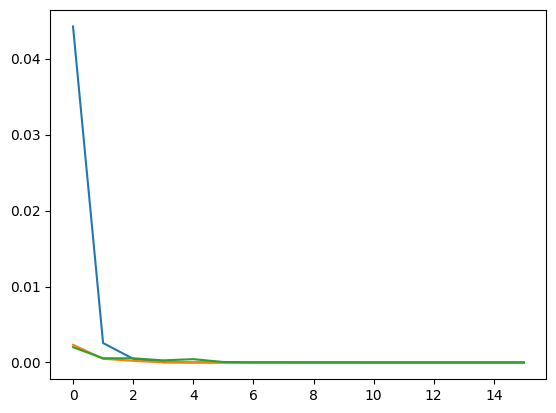

In [23]:
plt.plot(dpca.explained_variance_ratio_['t'])
plt.plot(dpca.explained_variance_ratio_['f'])
# plt.plot(dpca.explained_variance_ratio_['f'])
plt.plot(dpca.explained_variance_ratio_['ft'])
# plt.plot(dpca.explained_variance_ratio_['ft'])
# plt.plot(dpca.explained_variance_ratio_['sf'])


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['var', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


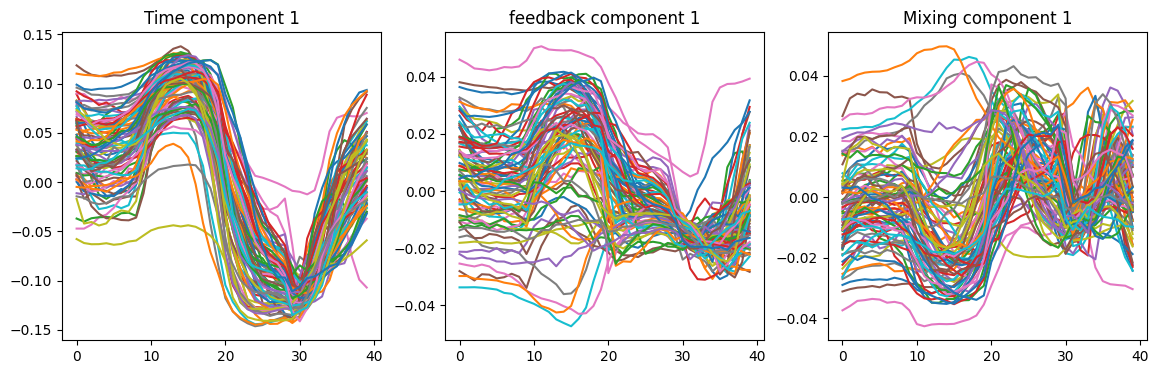

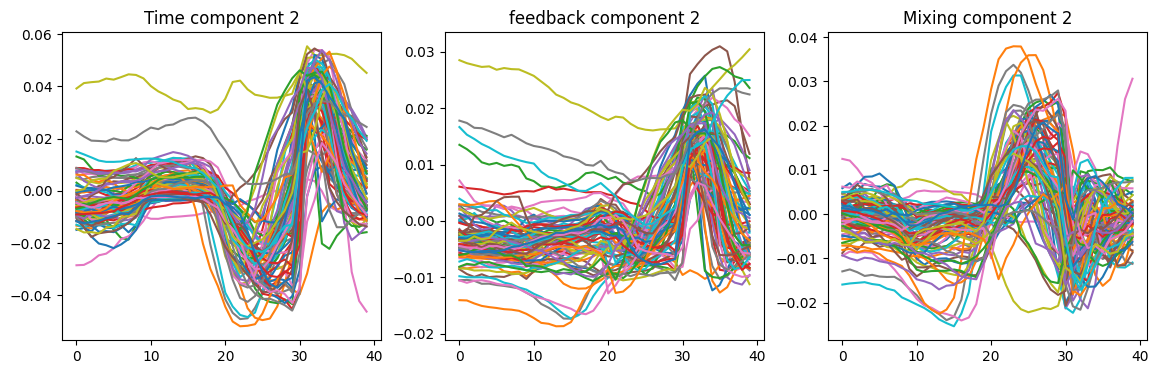

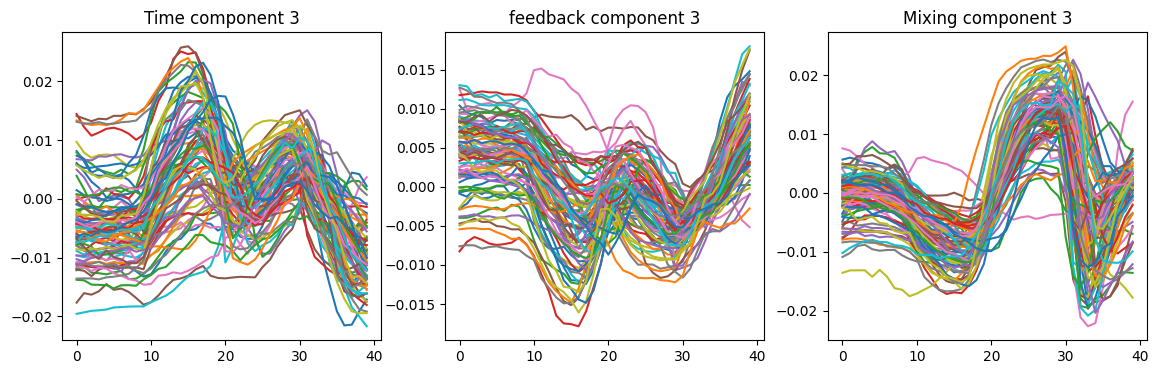

In [24]:
%pylab inline
from numpy import *
from numpy.random import rand, randn, randint

time = np.arange(timesteps)
var = 'feedback'

for c in range(3):
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    for s in range(stimulus_count):
        plt.plot(time,Z['t'][c,s])
    plt.title('Time component ' + str(c+1))
        
    plt.subplot(132)
    for s in range(stimulus_count):
        plt.plot(time,Z['f'][c,s])
    plt.title(str(var) + ' component ' + str(c+1))
        
    plt.subplot(133)
    for s in range(stimulus_count):
        plt.plot(time,Z['ft'][c, s])
    plt.title('Mixing component ' + str(c+1))
    plt.show()
